In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import speech_recognition as sr
import pyaudio
import wave
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import librosa
import IPython.display as ipd
import librosa.display

from pathlib import Path

from threading import Thread

In [2]:
ROOT = os.path.join(os.getcwd())
DDIR = os.path.join(os.getcwd(), 'dataset')
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
all_type = ['maju','belok_kiri','belok_kanan','serong_kiri','serong_kanan','stop','putar_balik_kiri', 'putar_balik_kanan', 'other']

In [3]:
def save_dataframe(df:pd.DataFrame, name:str):
    if not os.path.exists('excel'):
        os.makedirs('excel')
    df.to_excel(f'{os.path.join(ROOT, "excel", name)}.xlsx', index=False)
    return print(f'Saved as {name}.xlsx')

In [4]:
def many_files():
    total_files:int = 0
    total_directories:int = 0
    for x in os.listdir(DDIR):
        # print(x)
        print(f'{x}: {len(os.listdir(os.path.join(DDIR, x)))}')
        total_files += len(os.listdir(os.path.join(DDIR, x)))
        total_directories+=1
    print('-=====================-')
    print(f'Total files: {total_files}')
    print(f'Total directories: {total_directories}')

In [5]:
many_files()

belok_kanan: 40
belok_kiri: 40
maju: 71
other: 193
putar_balik_kanan: 40
putar_balik_kiri: 40
serong_kanan: 40
serong_kiri: 40
stop: 40
-=====================-
Total files: 544
Total directories: 9


In [6]:
from pydub import AudioSegment as am
for x in tqdm(os.listdir(DDIR)):
    for y in os.listdir(os.path.join(DDIR, x)):
        if y.endswith('.wav'):
            sound = am.from_wav(os.path.join(DDIR, x, y))
            sound = sound.set_channels(1)
            sound.export(os.path.join(DDIR, x, y), format='wav')

c:\Users\pande\AppData\Local\Programs\Python\Python310\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 20.38it/s]


In [7]:
def mfcc(audio_obj:str=None, frame_rate:int=2048, hop_len:int=512, mfcc_num:int=100, visualize:bool=True):
    signal, sr = librosa.load(audio_obj)
    mfcc_spectrum = librosa.feature.mfcc(y=signal, sr=sr, n_fft=frame_rate, hop_length=hop_len, n_mfcc=mfcc_num)
    # delta_1_mfcc = librosa.feature.delta(mfcc_spectrum, order=1)
    # delta_2_mfcc = librosa.feature.delta(mfcc_spectrum, order=2)

    mfcc_features = np.mean(mfcc_spectrum, axis=1)

    if visualize:
        plt.figure(figsize=(14, 15))
        plt.subplot(3, 1, 1)
        librosa.display.specshow(mfcc_spectrum, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC of {audio_obj}')

        plt.subplot(3, 1, 2)
        librosa.display.specshow(delta_1_mfcc, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC Delta 1 of {audio_obj}')

        plt.subplot(3, 1, 3)
        librosa.display.specshow(delta_2_mfcc, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC Delta 2 of {audio_obj}')

        plt.tight_layout()
        plt.show()
    return mfcc_features

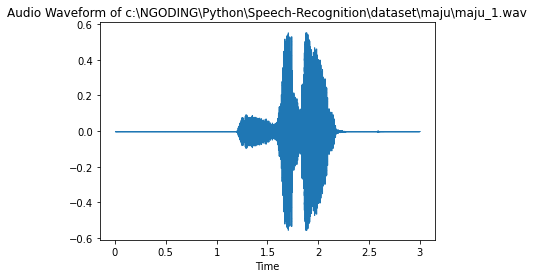

In [8]:
test_input = os.path.join(DDIR, 'maju', 'maju_1.wav')
audio_obj = ipd.Audio(test_input)
audio, sr = librosa.load(test_input)

librosa.display.waveshow(audio , sr=sr)
plt.title(f'Audio Waveform of {test_input}')
plt.show()

In [9]:
def audio_features(path:os.PathLike=DDIR, frame_size:int=2048, hop_len:int=512, mfcc_num:int=100):
    audios_mfcc,audios_label = [],[]
    audio_files = os.listdir(path)
    # print(audio_files)
    for audio_name in tqdm(audio_files):
        for audio in glob.glob(f'{os.path.join(DDIR , audio_name)}/*.wav'):
            mfcc_score = mfcc(audio_obj=audio, frame_rate=frame_size, hop_len=hop_len, mfcc_num=mfcc_num, visualize=False)
        # mfcc_score = mfcc(audio_obj=f'{os.path.join(path, audio_name)}', frame_rate=frame_size, hop_len=hop_len, mfcc_num=mfcc_num, visualize=False)
        
            audios_mfcc.append(mfcc_score)
            if(audio_name != 'other'):
                label = audio.split('\\')[-1].split('_')
                label = '_'.join(label[:len(label)-1])
            else:
                label = 'other'
            audios_label.append(label)

    # print(len(audios_mfcc), len(audios_zcr), len(audios_rmse), len(audios_label))
    # print(audios_mfcc[0].shape, audios_zcr[0].shape, audios_rmse[0].shape)
    audio_features = np.column_stack(audios_mfcc)
    # print(audio_features.shape)
    df = pd.DataFrame(audio_features)
    df = df.T
    # df.insert(loc=0, column='name', value=audio_label)
    df['label'] = audios_label

    return df

In [10]:
df = audio_features(path=DDIR, frame_size=2048, hop_len=512, mfcc_num=100)

100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


In [11]:
df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-422.895020,48.039368,-6.186774,5.216863,0.528688,0.511103,0.804288,-2.947132,-1.912176,-1.176030,...,0.210378,-0.140555,0.035365,0.327993,0.097341,-0.261531,-0.144780,-0.032475,-0.001613,belok_kanan
1,-452.015533,75.630280,3.107103,13.786242,10.602611,5.711093,9.261926,1.144305,-0.127123,4.809555,...,-0.385292,-0.396922,-0.195165,-0.274765,-0.303379,-0.565148,-0.229500,-0.267201,-0.383995,belok_kanan
2,-451.404572,79.344475,6.550086,13.724059,8.741273,5.700652,10.009722,4.446376,1.270512,4.347304,...,-0.593732,-0.846818,-0.305814,-0.309355,-0.451223,-0.471889,-0.150527,-0.357839,-0.259098,belok_kanan
3,-427.350311,74.012665,7.923713,17.727348,10.162389,3.991512,8.650618,0.311897,-0.763944,3.620642,...,-0.425157,-0.406701,-0.035334,0.104050,0.104159,0.058649,0.134681,-0.026266,-0.043817,belok_kanan
4,-429.572540,77.107819,-4.081679,11.423177,7.030103,0.563384,7.570338,-4.722734,-2.023028,2.345480,...,0.149114,-0.059289,-0.046067,-0.156633,-0.080537,-0.378049,-0.367593,-0.280759,-0.146725,belok_kanan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,-470.079376,45.747086,2.465739,9.245466,1.879421,4.611631,2.307523,-0.145610,2.615705,1.458428,...,-0.399299,0.284619,-0.086084,-0.261287,0.008039,0.062332,-0.542181,-0.849094,0.116537,stop
540,-458.152130,54.427341,10.859817,18.953602,12.116943,8.867125,3.898578,3.338180,5.552986,3.430444,...,-0.165850,-0.384982,-0.528454,-0.360275,0.248392,0.043351,-0.239375,-0.068425,0.230480,stop
541,-476.851288,33.758762,3.198869,18.945076,9.691606,5.707524,5.860674,2.288089,3.738406,4.480802,...,-0.358294,0.049894,-0.758487,-0.712967,0.095471,-0.591564,-0.945470,-0.110622,0.733492,stop
542,-460.523193,42.417267,2.463290,13.035515,12.209575,12.237802,9.284326,2.712193,3.275745,6.846437,...,0.161486,-0.459517,-0.297796,0.236673,0.043918,-0.808160,-0.217420,0.176083,-0.242040,stop


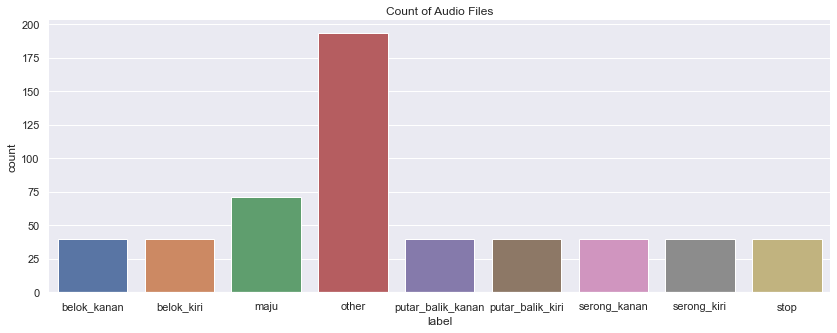

In [12]:
sns.set()
plt.figure(figsize=(14, 5))
sns.countplot(x='label', data=df)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.title('Count of Audio Files')
plt.show()

In [24]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split as tts

X = df.drop(['label'], axis=1)

scaler = MinMaxScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

# X = np.expand_dims(X, axis=-1)

# scaler = StandardScaler()
# X = scaler.fit_transform(X)
maps = {
    'maju': 0,
    'belok_kiri': 1,
    'belok_kanan': 2,
    'serong_kiri': 3,
    'serong_kanan': 4,
    'stop': 5,
    'putar_balik_kiri': 6,
    'putar_balik_kanan': 7,
    'other': 8
}

y = list(map(lambda x : maps[x], df['label']))

# y = pd.get_dummies(df['label']).values
# y = np.reshape(y, (len(y), 8,1))

# y = y.reshape(-1, 8)
# y = OneHotEncoder().fit_transform(df_fix['label'].values.reshape(-1, 1)).toarray()
# y = np.array(df_fix['label'].apply(lambda x : 1 if x == 'happy' else 0))

# y = np.reshape(y, (-1, 1))
# y = OneHotEncoder().fit_transform(y).toarray()

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

In [25]:
df['label'].value_counts()

other                193
maju                  71
belok_kanan           40
belok_kiri            40
putar_balik_kanan     40
putar_balik_kiri      40
serong_kanan          40
serong_kiri           40
stop                  40
Name: label, dtype: int64

In [26]:
from sklearn.svm import SVC
def svm_train(X_train, X_test, y_train, y_test, kernel:str='linear', C:float=1.0, gamma:str|int=None, dfs:str=None):
    svc = SVC(kernel=kernel, C=C, gamma=gamma, decision_function_shape=dfs, probability=True)
    svc.fit(X_train, y_train)
    y2 = svc.predict(X_test)
    return accuracy_score(y_test, y2)

In [27]:
def get_svm(X_train, X_test, y_train, y_test)->pd.DataFrame:
    df = pd.DataFrame(columns=['kernel', 'C', 'accuracy (%)','gamma','decision_function_shape'])
    list_gamma = [0.0001, 0.1, 1]
    list_dfs = ['ovo','ovr']
    for a in tqdm(list_dfs):
        for x in [1, 10, 100]:
            for y in ['linear', 'rbf', 'sigmoid']:
                for z in list_gamma:
                    acc = svm_train(X_train, X_test, y_train, y_test, y, x, gamma=z, dfs=a)
                    df = df.append({'kernel': y, 'C': x, 'accuracy (%)': acc.round(2), 'gamma': z, 'decision_function_shape':a}, ignore_index=True)
    return df

In [28]:
get_svm_score = get_svm(X_train, X_test, y_train, y_test)

100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


In [29]:
get_svm_score.sort_values(by='accuracy (%)', ascending=False)

,kernel,C,accuracy (%),gamma,decision_function_shape
22,rbf,100,0.97,0.1000,ovo
49,rbf,100,0.97,0.1000,ovr
10,linear,10,0.96,0.1000,ovo
20,linear,100,0.96,1.0000,ovo
19,linear,100,0.96,0.1000,ovo
18,linear,100,0.96,0.0001,ovo
36,linear,10,0.96,0.0001,ovr
37,linear,10,0.96,0.1000,ovr
38,linear,10,0.96,1.0000,ovr
11,linear,10,0.96,1.0000,ovo


In [30]:
get_svm_score.sort_values(by='accuracy (%)', ascending=False, inplace=True)

In [31]:
get_svm_score['rank'] = np.arange(1,len(get_svm_score)+1)

In [32]:
get_svm_score.set_index = get_svm_score['rank']

In [33]:
save_dataframe(get_svm_score, 'svm_score')

Saved as svm_score.xlsx


In [34]:
best = get_svm_score.iloc[0]

In [35]:
ticks_list = maps.keys()

In [38]:
ticks_list = list(ticks_list)
ticks_list

['maju',
 'belok_kiri',
 'belok_kanan',
 'serong_kiri',
 'serong_kanan',
 'stop',
 'putar_balik_kiri',
 'putar_balik_kanan',
 'other']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.67      0.80         6
           2       1.00      1.00      1.00         9
           3       0.85      1.00      0.92        11
           4       0.80      1.00      0.89         4
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        36

    accuracy                           0.97       109
   macro avg       0.96      0.94      0.95       109
weighted avg       0.98      0.97      0.97       109

Accuracy : 97.25%


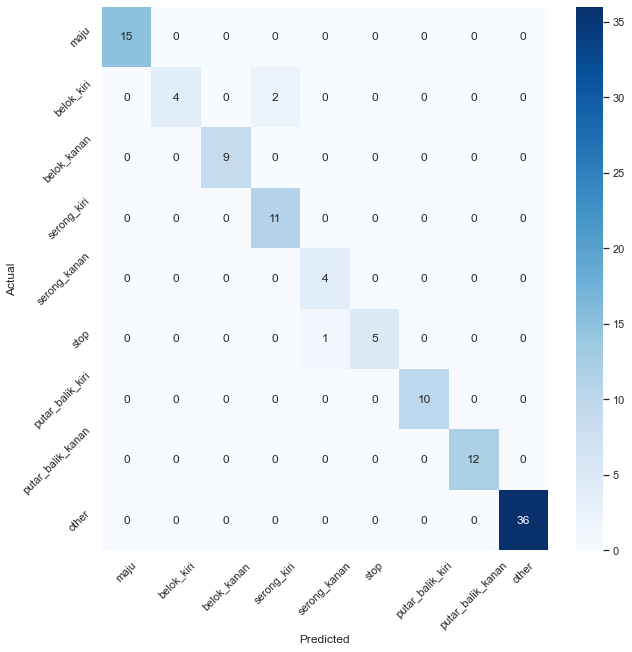

In [39]:
svm_score = SVC(kernel=best['kernel'],C=best['C'], gamma=best['gamma'], decision_function_shape=best['decision_function_shape'], probability=True)
svm_score.fit(X_train, y_train)
y_pred = svm_score.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Accuracy : {accuracy_score(y_test, y_pred).round(4)*100}%')
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.xticks(np.arange(9)+0.5, ticks_list, rotation=45)
plt.ylabel('Actual')
plt.yticks(np.arange(9)+0.5, ticks_list, rotation=45)
plt.show()

In [40]:
def prediction(model:object=None, df:pd.DataFrame=None):
    temp = df
    X = temp.drop(['label'], axis=1)
    # scaler = MinMaxScaler()
    X = scaler.transform(X)
    y = list(map(lambda x : maps[x], temp['label']))
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    fig = plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.xticks(np.arange(9)+0.5, ticks_list, rotation=45)
    plt.ylabel('Actual')
    plt.yticks(np.arange(9)+0.5, ticks_list, rotation=45)
    plt.show()
    
    for i in range(len(y)):
        print(f'Prediction for {temp["label"].iloc[i]}_{i+1} : {y_pred[i]}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      0.95      0.97        40
           2       1.00      1.00      1.00        40
           3       0.95      1.00      0.98        40
           4       0.98      1.00      0.99        40
           5       1.00      0.97      0.99        40
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00       193

    accuracy                           0.99       544
   macro avg       0.99      0.99      0.99       544
weighted avg       0.99      0.99      0.99       544



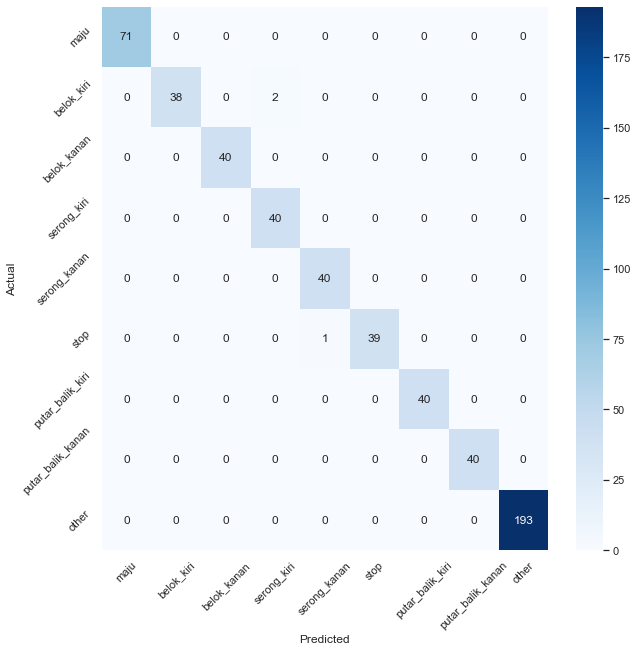

Prediction for belok_kanan_1 : 2
Prediction for belok_kanan_2 : 2
Prediction for belok_kanan_3 : 2
Prediction for belok_kanan_4 : 2
Prediction for belok_kanan_5 : 2
Prediction for belok_kanan_6 : 2
Prediction for belok_kanan_7 : 2
Prediction for belok_kanan_8 : 2
Prediction for belok_kanan_9 : 2
Prediction for belok_kanan_10 : 2
Prediction for belok_kanan_11 : 2
Prediction for belok_kanan_12 : 2
Prediction for belok_kanan_13 : 2
Prediction for belok_kanan_14 : 2
Prediction for belok_kanan_15 : 2
Prediction for belok_kanan_16 : 2
Prediction for belok_kanan_17 : 2
Prediction for belok_kanan_18 : 2
Prediction for belok_kanan_19 : 2
Prediction for belok_kanan_20 : 2
Prediction for belok_kanan_21 : 2
Prediction for belok_kanan_22 : 2
Prediction for belok_kanan_23 : 2
Prediction for belok_kanan_24 : 2
Prediction for belok_kanan_25 : 2
Prediction for belok_kanan_26 : 2
Prediction for belok_kanan_27 : 2
Prediction for belok_kanan_28 : 2
Prediction for belok_kanan_29 : 2
Prediction for belok_ka

In [41]:
prediction(svm_score, df)

In [42]:
import pickle

def save_model(model:object=None, name:str=None):
    if not os.path.exists('model'):
        os.makedirs('model')
    pickle.dump(model, open(f'{os.path.join(ROOT, "model", name)}.pkl', 'wb'))
    return print(f'Saved as {name}.pkl')

save_model(svm_score, 'svm_model_speech_recognition')

save_model(scaler, 'svm_scaler_speech_recognition')

Saved as svm_model_speech_recognition.pkl
Saved as svm_scaler_speech_recognition.pkl
